Aufgaben die zu erledigen sind:
- Product Shelf bereinigen --> schlecht gekaufte Produkte
- Produkte empfehlen die noch nicht eingekauft wurden

3 mögliche Systeme:
- Simple Recommender --> Top Products
    - Decide on the metric or score to rate products on
    - Calcualte the score for every product
    - Sort the products based on the score and output the top results
    
- Content Based Recommender --> Uses item meta data
- Collaborative Recommender --> Products from other user that looks pretty similar


Problems:
Contrarian to rating data, purchase data has no upper band of the evaluated score
There is no explicit rating data, so it has to be generated from implicit information available

Ressources:
- https://medium.com/datadriveninvestor/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6
- https://www.datacamp.com/community/tutorials/recommender-systems-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=229765585186&utm_targetid=aud-299261629574:dsa-473406569915&utm_loc_interest_ms=&utm_loc_physical_ms=20143&gclid=Cj0KCQiA-bjyBRCcARIsAFboWg2VIh0dOVFJAckISmcG52iT4y1gr732tQkw-i9-Pj2VubR5WXq4IWcaArhsEALw_wcB


Performance:
This might be an issue.
A possible solution is: https://towardsdatascience.com/how-to-analyse-100s-of-gbs-of-data-on-your-laptop-with-python-f83363dda94


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # used for histogram


data = pd.read_csv ("Recommender4Retail.csv", index_col=[0]) # low_memory option is depricated
data.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
1,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,dairy eggs,soy lactosefree
3,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,snacks,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky
5,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods


Description of the attributes (According to https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)

- order_id: order identifier
- user_id: user identifier
- eval_set: which evaluation set this order belongs in (we only have Prior and Train) - no test?
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- order_hour_of_day: the hour of the day the order was placed on
- days_since_prior_order: days since the last order, capped at 30 (with NaNs for order_number = 1)
- product_id: product identifier
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise
- product_name: name of the product
- aisle_id: aisle identifier
- department_id: department identifier
- department: the name of the department
- ailse: the name of the aisle



In [8]:
# Exploring the Data
'''
- What is eval_set, order_dow, reordered and can what can they be used for?
- Can the amount a product has been bought, seen as a implicit ratings? There might be some problems to it depending on the product...
- 
'''
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 1 to 33819106
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  department              object 
 14  aisle                   object 
dtypes: float64(1), int64(10), object(4)
memory usage: 4.0+ GB


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.174104e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07
mean,1.710566e+06,1.029444e+05,1.713998e+01,2.737285e+00,1.343123e+01,1.136415e+01,2.557551e+04,8.367738e+00,5.900617e-01,7.121799e+01,9.918544e+00
std,9.874008e+05,5.946733e+04,1.749829e+01,2.093296e+00,4.246149e+00,8.940500e+00,1.409770e+04,7.139540e+00,4.918220e-01,3.819898e+01,6.281655e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.554130e+05,5.143500e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,1.351900e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00
50%,1.710660e+06,1.026260e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00
75%,2.565587e+06,1.544120e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,3.793500e+04,1.100000e+01,1.000000e+00,1.070000e+02,1.600000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01


In [10]:
#Unique Values for specified colums
cols = ('eval_set','order_dow','reordered')
for var in cols:
    res = data[var].unique()
    print('{2}: UniqueValues {0}, No. of unique values {1} '.format(res,len(res),var))


#Count occurence of each value
#print(data.eval_set.value_counts())

eval_set: UniqueValues ['prior' 'train'], No. of unique values 2 
order_dow: UniqueValues [2 3 4 1 5 0 6], No. of unique values 7 
reordered: UniqueValues [0 1], No. of unique values 2 


user_id
201268    3725
129928    3689
164055    3089
176478    2952
186704    2936
137629    2931
182401    2929
33731     2912
108187    2760
4694      2735
Name: product_id, dtype: int64


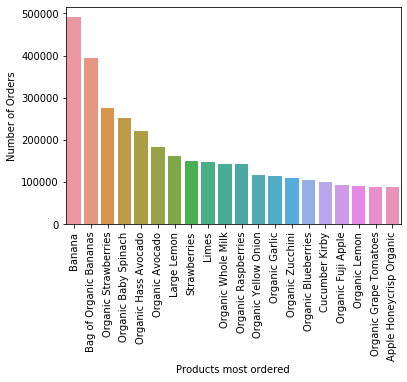

In [9]:
# number of departments
n_of_departments = data.department.nunique()

# amount of products bought by user
# show the top 10 user with most products bought
n_by_user = data.groupby('user_id')['product_id'].count()
print(n_by_user.nlargest(10))

# number of times a product is bought
# show the products most bought
n_of_products_bought = data.product_name.value_counts()
n_of_products_bought_20 = n_of_products_bought.nlargest(20)

plt.figure()
sns.barplot(x=n_of_products_bought_20.index, y=n_of_products_bought_20.values)
plt.xlabel('Products most ordered')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.savefig('prod_most_bought.png', bbox_inches='tight')
plt.show()

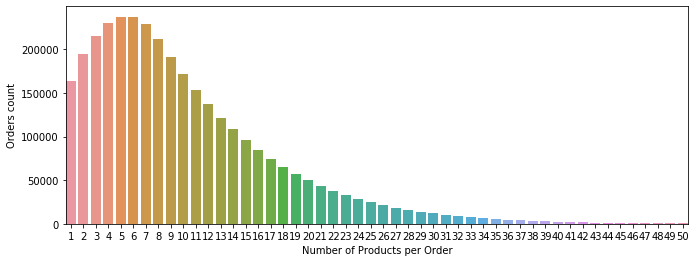

In [23]:
# Number of products bought per order
n_prod_order = data.groupby('order_id')['product_id'].count().value_counts().sort_index() # first row = number of products per order, second row = how many orders
# This does not consider if a product is bought multiple times in one order, but i guess thats not in the dataset anyways?

n_prod_order_n = n_prod_order.head(50) # limit to only plot the first n values

plt.figure()
sns.barplot(x=n_prod_order_n.index, y=n_prod_order_n.values)
plt.xlabel('Number of Products per Order')
plt.ylabel('Orders count')

# Adjust the lenght of the plot. Source: https://stackoverflow.com/questions/44863375/how-to-change-spacing-between-ticks-in-matplotlib
N = 50
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*N+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.savefig('n_prod_order.png')
plt.show()


department
produce            9888378
dairy eggs         5631067
snacks             3006412
beverages          2804175
frozen             2336858
pantry             1956819
bakery             1225181
canned goods       1114857
deli               1095540
dry goods pasta     905340
Name: product_name, dtype: int64


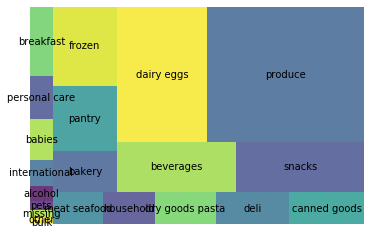

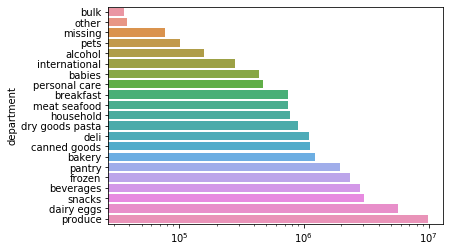

In [11]:
# Number of Orders per Department
p_c = data.groupby('department')['product_name'].count().sort_values()

print(p_c.nlargest(10))

# plot as Treemap
import squarify
squarify.plot(sizes=p_c.values, label=p_c.index, alpha=.8 )
plt.axis('off')
plt.savefig('departments_treemap.png')
plt.show() 

# maybe better as a barplot
plt.figure()
sns.barplot(x=p_c.values, y=p_c.index)
#plt.barh(y_pos,p_c.values)
#plt.yticks(y_pos, p_c.index)
#y_pos = np.arange(len(p_c.values))
plt.xscale('log')
plt.savefig('departments_bar.png', bbox_inches='tight')
plt.show()


In [44]:
# Number of Products per Department
n_p = data.groupby('department')['product_name'].value_counts()
print(n_p.head(10))

# Number of purchases per Category / Subcategory
p_c_s = data.groupby('department')['aisle'].value_counts()
print(p_c_s.head(10))

department  product_name      
alcohol     Sauvignon Blanc       8541
            Cabernet Sauvignon    6352
            Chardonnay            6346
            Beer                  6068
            Vodka                 5666
            India Pale Ale        4402
            Pinot Noir            4116
            Pinot Grigio          3351
            Malbec                2542
            Chardonnay Wine       2075
Name: product_name, dtype: int64


In [ ]:
# looking at a specific user / product transaction
data[(data.user_id == 1) & (data.product_id == 196)]

After the EDA part, the number of products needs to be reduced
According to the Aufgabenstellung, the product shelf should be reduced by 80%, and products less often bought should be removed

The total Number of Products are 49685. If selected the top 20% most bought that leaves a total of 9937 products

The total number of transactions are 33'819'106. When filtered to only include the top 20% product transactions, this leaves us still with 30'749'657

In [4]:
# number of products
n_of_products = data.product_name.nunique()

# 20% of the products are
top_20 = int(n_of_products * 0.2)

# select the top products
top_products = n_of_products_bought.nlargest(top_20).index

# filter the transactions only for the top products
data_f = data[(data.product_name.isin(top_products))]

# Recommender Building
This is done in several steps<p>
1. Preparing the data<p>
2. Running the Recommender<p>
3. Evaluating the results<p>

Explain the difference between content based, collaborative filtering and memory based methods here....

In [5]:
# for testing and resource purposes, the set of transactions is reduced
data_f = data_f.head(10000)

# create a matrix with user, product and occurence as value (= number of times purchased)
''' depricated
matrix = pd.crosstab(data.user_id, data.product_id) 
# if we want precentage add parameter normalize=True

# this could alternatively be done by groupby
matrix_g = data.groupby(['user_id', 'product_id'])['product_id'].count().unstack().fillna(0)
'''
# with pivot_table - already normalized the ratings
# sigmoid function - this could alternatively be done with percentages
func = lambda x: x.count() / (1+x.count())
pivot_data = data_f[['user_id','product_id']]
matrix_p = pivot_data.pivot_table(index='user_id',columns='product_id',values='product_id',aggfunc=func,fill_value=0)

matrix_p.reset_index(inplace=True)

matrix_p.head(1)
# the matrix has a lot of empty values (is very sparse)

product_id,user_id,23,34,45,79,93,95,100,116,117,...,49519,49520,49533,49585,49588,49615,49628,49655,49680,49683
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
''' depricated
# converting the matrix back to a table for further processing
v_table = matrix.stack().reset_index()
v_table.columns = ['user_id','product_id','amount']

# remove rows with amount = 0
v_table = v_table[(v_table.amount != 0)]

print(v_table.head())

x = data.groupby(['user_id','product_id']).size()

print(x.head(20))

# Amount of times a product has been bought needs to be turned into a rating with range 0-1
# Not sure if sigmoid function or percentage is better, lets try both
v_table['rating_sig'] = v_table.amount / (1+v_table.amount)
v_table['rating_per'] = v_table.amount / v_table.amount.sum()
v_table.head()

# Renaming the column 'amount' to rating, since in the context of a recommender it's handeled as a rating
#v_table = v_table.rename(columns={'amount': 'rating'})

#Creating a dataframe with the number of ratings and the average rating for each product

# Getting the average rating of all products (Maybe this 'amount' value has to be converted to a fixed scale before?)
ratings = pd.DataFrame(v_table.groupby('product_id')['rating_sig'].mean())

# Add the number of times a Product has been bought/rated to the df
ratings['number_of_ratings'] = v_table.groupby('product_id')['amount'].count()

ratings.head()

# Lets look at the distribution of the ratings

import matplotlib.pyplot as plt
%matplotlib inline
ratings['number_of_ratings'].hist(bins=50)

ratings.sort_values('number_of_ratings', ascending=False).head(10)
'''

In [6]:
# geting a random product

random_product = data_f.sample(1)

print(random_product.product_name)

4232    Total 2% with Strawberry Lowfat Greek Strained...
Name: product_name, dtype: object


In [7]:
# this is a simple version of a collaborative filtering - memory based - recommender. It looks at similarities between a product and every other product in the catalog (matrix)
# this model requires no information about the product (or user). The more transactions there are the "better" the recommender becomes.
# a content-based approach is most likely not possible since there isn't much information about the product itself and no information about the user whatsoever

# Calculating the correlation between a product and the catalog

def recommend (product):
    r = matrix_p.corrwith(matrix_p[product])
    res = r.sort_values(ascending=False)[1:6] #the first product is always itself and therefore needs to be filtered
    print(res) 
    
    # print the results
    prod = data_f[(data.product_id == product)].product_name.unique()
    prod_r = data_f[(data.product_id.isin(res.index.tolist()))].product_name.unique()
    print('For {0}, the recommended products are {1}f'.format(prod,prod_r))

recommend(random_product.product_id.values[0])

# with an user-user recommender: maybe filter out the products the user has already bought?


product_id
22124    0.825800
40571    0.802313
24954    0.765544
1559     0.764117
4957     0.758430
dtype: float64
For ['Total 2% with Strawberry Lowfat Greek Strained Yogurt'], the recommended products are ['Total 0% Raspberry Yogurt' 'Cherry Pomegranate Greek Yogurt'
 'Total 0% with Honey Nonfat Greek Strained Yogurt'
 'Total 2% Lowfat Greek Strained Yogurt With Blueberry'
 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz']f


In [ ]:
# a memory based recommender doesnt perform well if the information is sparse - https://youtu.be/v_mONWiFv0k
# calculate the sparcity: # of ratings / total # elements
# in theory the recommender should work better with items which have been bought by many different users. Since the matrix is built with transaction data, each product is at least bought by one person

In [ ]:
# Matrix Factorization Model

